Note: potentially useful MJO packages (for future use)  
https://mdtf-diagnostics.readthedocs.io/en/latest/sphinx_pods/MJO_suite.html  
https://github.com/NOAA-GFDL/MDTF-diagnostics/tree/main/diagnostics/MJO_prop_amp

## Load pre-computed data? (and set data directory)

In [1]:
LOAD = True
data_dir = '/vortexfs1/scratch/kcarr/era-interim'

In [2]:
# Utilities
import os
from os.path import join
from copy import deepcopy

# Analysis modules
import xarray as xr
from eofs.xarray import Eof
import numpy as np
import pandas as pd

# Plotting modules
import matplotlib.pyplot as plt
# plt.rcParams['figure.dpi'] = 144 # set resolution
# plt.rcParams["figure.autolayout"] = True # prevent axes from being cutoff
import seaborn as sns
sns.set()
from multiprocessing import Pool
from matplotlib.colors import ListedColormap
from matplotlib.collections import LineCollection
from collections import Counter
import cartopy.crs as ccrs
import cmocean

# Custom toolboxes
import spectral
from toolbox import *

# Pre-process data (or load pre-computed data)

In [3]:
if LOAD:
    print('Loading pre-computed data')
    ##### Read in de-trended and de-seasonalized data
    oni = xr.open_dataarray(os.path.join(data_dir, 'oni.nc'))
    oni_daily = xr.open_dataarray(os.path.join(data_dir, 'oni_daily.nc'))
    olr = xr.open_dataarray(os.path.join(data_dir, 'olr_prep.nc'))
    u = xr.open_dataarray(os.path.join(data_dir, 'u_prep.nc'))
    v = xr.open_dataarray(os.path.join(data_dir, 'v_prep.nc'))
    tp = xr.open_dataarray(os.path.join(data_dir, 'tp_prep.nc'))
    tp_us = xr.open_dataarray(os.path.join(data_dir, 'tp_us_prep.nc'))
    mjo_data = xr.open_dataarray(os.path.join(data_dir, 'mjo_data.nc'))

else:
    print('Pre-processing data')
    # read in raw data
    sst = xr.open_dataset(join(data_dir, 'sst.mon.mean.nc')).sst
    olr = xr.open_dataset(join(data_dir, 'ttr_daily.nc')).ttr
    olr = -olr / (12*3600) # convert units from J/m^2 to W/m^2, and flip sign
    u = xr.open_dataset(join(data_dir, 'u_daily.nc')).u
    v = xr.open_dataset(join(data_dir, 'v_daily.nc')).v
    tp = xr.open_dataset(join(data_dir, 'tp_daily.nc')).tp
    tp_us = xr.open_dataset(join(data_dir, 'tp_us_daily.nc')).tp
    tp_us = tp_us * 1000*2*30 # convert from m/[12-hr] to mm/month

    # compute ONI anomalies (ENSO index)
    sst = sst.sel(longitude=slice(190,240),latitude=slice(5,-5)) # Nino 3.4 region
    sst = sst - get_trend_fast(sst)
    sst = remove_season(sst, standardize=False)[0]
    oni = sst.mean(dim=['longitude','latitude']).rolling(time=3).mean()
    # interpolate to daily
    oni_daily = oni.interp(time=pd.date_range('1979-01-01', '2017-12-02', freq='D'))
    
    # MAKE SURE TIMES MATCH
    oni_daily = oni_daily.isel(time=slice(None,-1)) # Get rid of extra time step
    olr = olr.isel(time=slice(None,-1))
    tp = tp.isel(time=slice(None,-1))
    tp_us = tp_us.isel(time=slice(None,-1))
    olr['time'] = oni_daily.time # set times equal
    tp['time'] = oni_daily.time
    u['time'] = oni_daily.time
    v['time'] = oni_daily.time
    tp_us['time'] = oni_daily.time
    oni_daily = oni_daily.isel(time=slice(60,None)) # Remove first 60 time steps
    u = u.isel(time=slice(60,None))
    v = v.isel(time=slice(60,None))
    tp = tp.isel(time=slice(60,None))
    olr = olr.isel(time=slice(60,None))
    tp = tp.isel(time=slice(60,None))
    tp_us = tp_us.isel(time=slice(60,None))
    
    # remove trend and seasonal cycle from atmospheric data
    res = []
    for d in[olr, u, v, tp, tp_us]:
        res.append(prep(d))

    # unpack results    
    olr, u, v, tp, tp_us = res
    
    # prep MJO data (i.e. remove ENSO, average over latitudes, divide by global var)
    u200_mjo = prep_mjo_data(u.sel(level=200).drop('level'))
    u850_mjo = prep_mjo_data(u.sel(level=850).drop('level'))
    olr_mjo = prep_mjo_data(olr)
    mjo_data = xr.concat([u200_mjo, u850_mjo, olr_mjo],
                         dim=pd.Index(['u200','u850','olr'], name='variable'))
    mjo_data = mjo_data.transpose('time',...)
    mjo_data = mjo_data - mjo_data.mean (dim='time') # make sure data is centered at 0

    ##### SAVE RESULTS
    oni.to_netcdf(os.path.join(data_dir, 'oni.nc'))
    oni_daily.to_netcdf(os.path.join(data_dir, 'oni_daily.nc'))
    olr.to_netcdf(os.path.join(data_dir, 'olr_prep.nc'))
    u.to_netcdf(os.path.join(data_dir, 'u_prep.nc'))
    v.to_netcdf(os.path.join(data_dir, 'v_prep.nc'))
    tp.to_netcdf(os.path.join(data_dir, 'tp_prep.nc'))
    tp_us.to_netcdf(os.path.join(data_dir, 'tp_us_prep.nc'))
    mjo_data.to_netcdf(os.path.join(data_dir, 'mjo_data.nc'))
    
# mask precipitation data
lsm = xr.open_dataset(join(data_dir, 'invariants.nc')).lsm.squeeze('time', drop='True')
lsm =lsm.interp(latitude=tp_us.latitude, longitude=tp_us.longitude)
cutoff=.3
lsm.values[lsm < cutoff] = 0.
lsm.values[lsm >= cutoff] = 1.
tp_us = tp_us * lsm

# get latitude and longitude for continental US
lon = tp_us.longitude
lat = tp_us.latitude

Loading pre-computed data


# EOFs

In [4]:
eof_obj = Eof(mjo_data) #### EOF analysis to get MJO index

# Get 1st two principal components (used to identify MJO phase)
rmm = eof_obj.pcs(pcscaling=1, npcs=3)
eofs = eof_obj.eofs(eofscaling=2, neofs=3)

# Reverse signs to match Wheeler-Hendon paper
rmm = -rmm
eofs = -eofs

# select first two modes for MJO index
rmm1 = rmm.sel(mode=0)
rmm2 = rmm.sel(mode=1)
pc3  = rmm.sel(mode=2)

# check reconstruction
res2 = np.einsum('ab,bcd->acd', eof_obj.pcs(pcscaling=1), eof_obj.eofs(eofscaling=2)).reshape(mjo_data.shape)
print(np.allclose(mjo_data, res2))

##### Determine MJO phases ######
mjo_phase = np.nan * deepcopy(rmm1)
mjo_phase.values = np.apply_along_axis(func1d=get_mjo_phase_, 
                                       arr=np.stack([rmm1.values,rmm2.values],axis=1), 
                                       axis=1)

True


# Plots

### Leading EOFs and explained variance

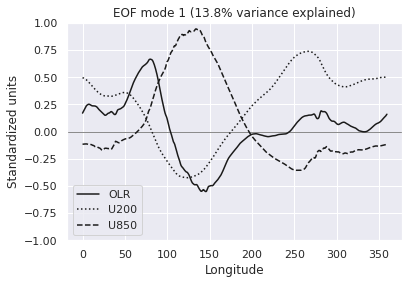

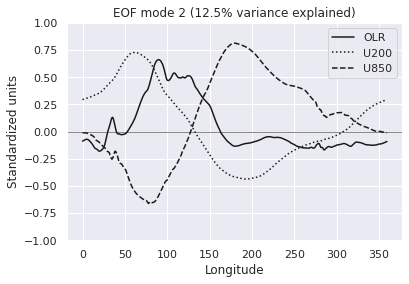

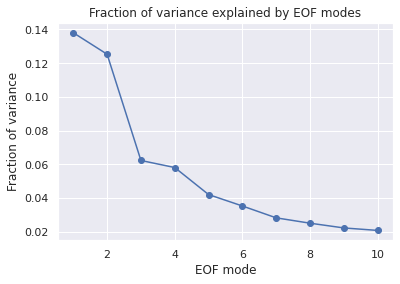

In [5]:
####### Plot the two dominant EOFs (corresponding to the RMM index)
for mode in [0,1]:
    fig,ax=plt.subplots()
    ax.plot(eofs.longitude, eofs.sel(mode=mode, variable='olr'), label='OLR', color='k')
    ax.plot(eofs.longitude, eofs.sel(mode=mode, variable='u200'), label='U200', color='k', linestyle=':')
    ax.plot(eofs.longitude, eofs.sel(mode=mode, variable='u850'), label='U850', color='k', linestyle='--')
    ax.axhline(y=0,color='k', linewidth=.5)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Standardized units')
    ax.set_ylim([-1,1])
    v1 = eof_obj.varianceFraction(neigs=2).values[mode].item()
    ax.set_title(f'EOF mode {mode+1} ({100*v1:.1f}% variance explained)')
    ax.legend()
    fig.savefig(f'figs/eof_{mode}.png')
    plt.show()
    
##### Explained variance #######
n=10
fig,ax=plt.subplots()
ax.plot(np.arange(1,n+1), eof_obj.varianceFraction(neigs=n))
ax.scatter(np.arange(1,n+1), eof_obj.varianceFraction(neigs=n))
ax.set_xlabel('EOF mode')
ax.set_ylabel('Fraction of variance')
ax.set_title('Fraction of variance explained by EOF modes')
fig.savefig(f'figs/eof_expvar.png')
plt.show()

## MJO phase composites

#### OLR/U composite

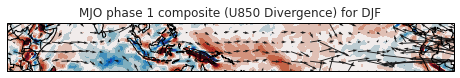

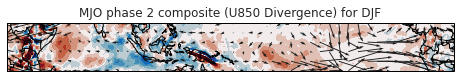

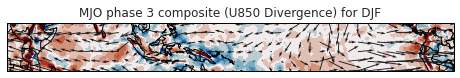

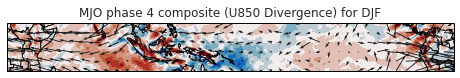

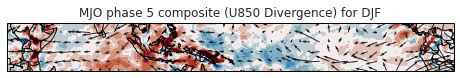

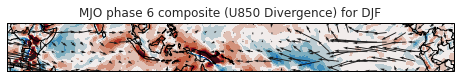

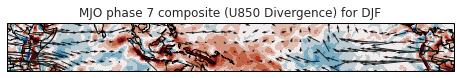

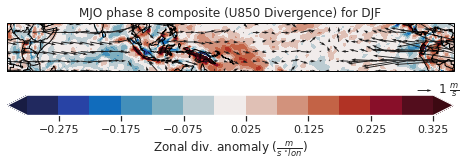

In [6]:
DJF = True # only plot composite for DJF months?
lev = 850 # one of {200,850}
u_x = u.differentiate(coord='longitude') # divergence

n=8 # plot every nth vector in the plots
for phase in np.arange(1,9): # do for each of the 8 phases
    d = mjo_phase[mjo_phase==phase].time
    if DJF: # get DJF months
        d = d[(d.dt.month == 12) | (d.dt.month == 1) | (d.dt.month == 2)] 
    phase_composite = olr.sel(time=d).mean(dim='time') # get OLR composite
    div_composite = u_x.sel(time=d).mean(dim='time')
    
    # Wind
    u_composite = u.sel(time=d, level=lev).mean(dim='time')
    v_composite = v.sel(time=d, level=lev).mean(dim='time')
#     fig, ax = plot_setup(plot_range=[20,300,-15,15],
#                                central_lon=180,figsize=(8,3))
#     ax.set_title(f'MJO phase {phase} composite (OLR & U{lev}) for DJF')
#     cp = ax.contourf(phase_composite.longitude, phase_composite.latitude, 
#                      phase_composite, cmap='cmo.balance', extend='both', 
#                      transform=ccrs.PlateCarree(), levels=np.arange(-34,38,4))
#     qv = ax.quiver(u.longitude.values[::n], # plot wind
#                    u.latitude.values[::n],
#                    u_composite[::n,::n],
#                    v_composite[::n,::n], width=.002)
#     ax.quiverkey(qv, X=.95, Y=-.4, U=1,
#              label=r'1 $\frac{m}{s}$', labelpos='E')
#     fig.savefig(f'figs/mjo_olr2_{phase}.png', bbox_inches = 'tight')
#     plt.show()
    
    # Divergence
    fig, ax = plot_setup(plot_range=[20,300,-15,15],
                               central_lon=180,figsize=(8,3))
    ax.set_title(f'MJO phase {phase} composite (U{lev} Divergence) for DJF')
    cp2 = ax.contourf(div_composite.longitude, div_composite.latitude, 
                     div_composite.sel(level=lev), cmap='cmo.balance', extend='both', 
                     transform=ccrs.PlateCarree(), levels=np.arange(-.325,.375,.05))
    qv = ax.quiver(u.longitude.values[::n], # plot wind
               u.latitude.values[::n],
               u_composite[::n,::n],
               v_composite[::n,::n], width=.002)
    ax.quiverkey(qv, X=.95, Y=-.4, U=1,
             label=r'1 $\frac{m}{s}$', labelpos='E')
    if phase==8:
        cb2 = fig.colorbar(cp2, orientation='horizontal', label=r'Zonal div. anomaly ($\frac{m}{s~^{\circ}lon}$)', fraction=.15)\
#         print('hi')
#         cb = fig.colorbar(cp, orientation='horizontal', label=r'OLR anomaly ($W/m^2$)', fraction=.15)
#     fig.savefig(f'figs/mjo_div_{phase}.png', bbox_inches = 'tight')
    plt.show()
#     break

### plot sample of MJO phase

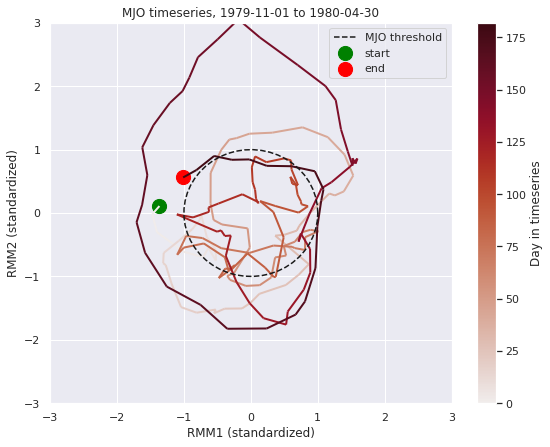

In [10]:
theta = np.linspace(0,2*np.pi)
x0 = np.cos(theta)
y0 = np.sin(theta)
year = 1979
d1 = f'{year}-11-01'
d2 = f'{year+1}-04-30'
x = rmm1.sel(time=slice(d1,d2))
y = rmm2.sel(time=slice(d1,d2))

fig,ax = plt.subplots(figsize=(9,7))
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = plt.Normalize(0, len(x))
lc = LineCollection(segments, cmap='cmo.amp', norm=norm)
lc.set_array(np.arange(len(x)))
lc.set_linewidth(2)
line = ax.add_collection(lc)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
ax.scatter(x[0],y[0],marker='o', s=200, label='start', color='green')
ax.scatter(x[-1],y[-1],marker='o', s=200, label='end', color='red')
ax.plot(x0,y0, linestyle='--', color='k', label='MJO threshold')
ax.set_xlabel('RMM1 (standardized)')
ax.set_ylabel('RMM2 (standardized)')
ax.set_title('MJO timeseries, 1979-11-01 to 1980-04-30')
ax.legend()
fig.colorbar(line, label='Day in timeseries')
plt.show()

### MJO composite for precipitation

Use significance testing!!!!!!!!  
estimate mean and standard error for the estimate (std dev divided by M^2)  
how to create standardized plots (divide by standard error? or standard deviation?)  
compare to 0 (using standard hypothesis test and monte carlo)  

Do montecarlo test to get significance for composite plots

#### ENSO precip composites

try alternating pairs of months for MJO

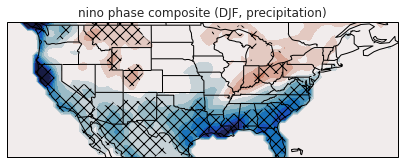

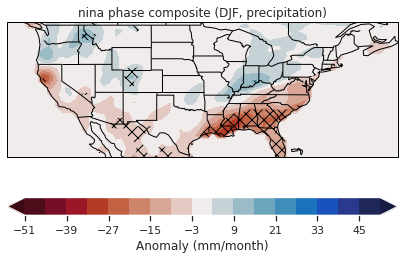

In [7]:
## enso
oni_djf = get_djf(oni_daily)
n = int((len(oni_djf[oni_djf > 1]) + len(oni_djf[oni_djf<-1]))/2)
lb,ub = mc_test_composite(data=tp_us, n_samples=n, n_sims=1000)

for phase in ['nino','nina']:
    if phase=='nino':
        t = oni_djf[oni_djf > 1].time
    else:
        t = oni_djf[oni_djf <-1].time
    M = len(t)
    p = tp_us.sel(time=t).mean(dim='time')
    sig = (p < lb) | (p > ub) # get montecarlo signicance bounds
    
    # plot
    fig,ax = plot_setup(plot_range=[lon[0],lon[-1],lat[-1],lat[0]])
    cp = ax.contourf(p.longitude, p.latitude, p, 
                     cmap='cmo.balance_r', levels=np.arange(-51,57,6), extend='both')
    h = ax.contourf(p.longitude, p.latitude, sig, hatches=[None,None,'xx'],colors='none',
                       extend='both', levels=[.25, .75])
    if phase=='nina':
        cb = fig.colorbar(cp, orientation='horizontal', label='Anomaly (mm/month)')
    ax.set_title(f'{phase} phase composite (DJF, precipitation)')
    plt.show()

#### MJO precip composites

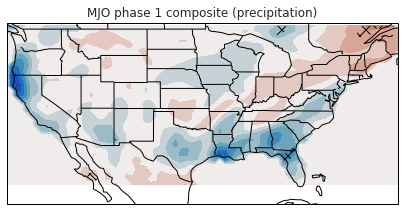

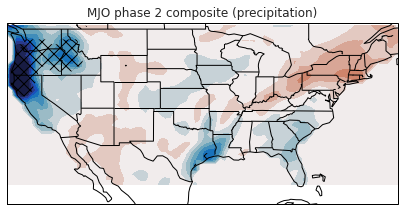

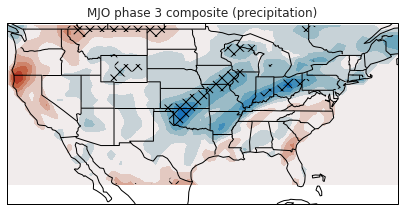

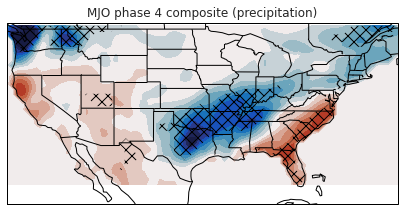

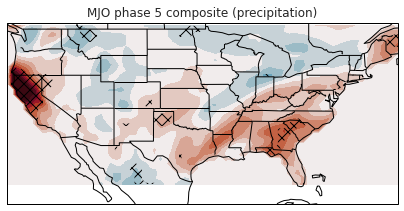

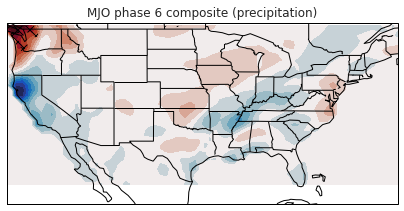

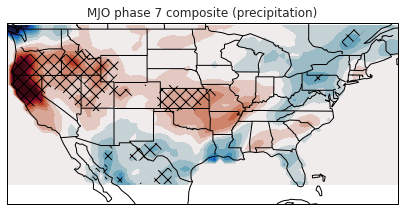

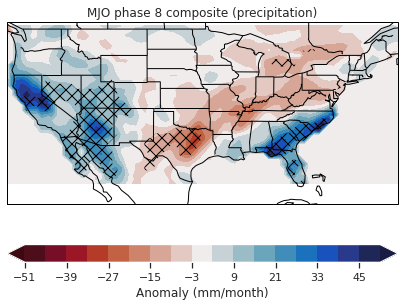

In [9]:
mjo_phase_djf = get_djf(mjo_phase)
n = int(np.sum(mjo_phase_djf>0)/8) # Get number of samples to draw for test
lb,ub = mc_test_composite(data=tp_us, n_samples=n, n_sims=1000) # montecarlo test

for phase in range(1,9):
    t = mjo_phase_djf[mjo_phase_djf==phase].time
    M = len(t)
    p = tp_us.sel(time=t).mean(dim='time')
#     p_std = tp_us.sel(time=t).mean(dim='time') / M
#     p_stderr = tp_us.sel(time=t).std(dim='time') / np.sqrt(M) 
    sig = (p < lb) | (p > ub) # get montecarlo signicance bounds
    
    # plot
    fig,ax = plot_setup()
    cp = ax.contourf(p.longitude, p.latitude, p, 
                     cmap='cmo.balance_r', levels=np.arange(-51,57,6), extend='both')
    h = ax.contourf(p.longitude, p.latitude, sig, hatches=[None,None,'xx'],colors='none',
                       extend='both', levels=[.25, .75])
    if phase==8:
        cb = fig.colorbar(cp, orientation='horizontal', label='Anomaly (mm/month)')
    ax.set_title(f'MJO phase {phase} composite (precipitation)')
    plt.show()

# Analysis
- power spectrum (ENSO RMM components, and precip)
- linear regression
- neural net
- stochastic model (?)

#### RMM lagged correlation

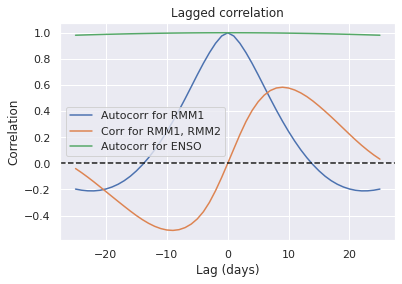

Correlation with ENSO
RMM1: -0.098
RMM2: -0.043


In [11]:
rmm1_rho = get_lagged_autocorr(rmm1)
rmm2_rho = get_lagged_autocorr(rmm2)
rmm1_rmm2_rho = get_lagged_corr(rmm1,rmm2)
enso_rho = get_lagged_autocorr(oni_daily)
    
# Lagged correlation plots
fig,ax = plt.subplots()
ax.plot(np.arange(-25,26), rmm1_rho, label = r'Autocorr for RMM1')
# ax.plot(np.arange(-25,26), rmm2_rho, label = r'Autocorr for RMM2')
ax.plot(np.arange(-25,26), rmm1_rmm2_rho, label = r'Corr for RMM1, RMM2')
ax.plot(np.arange(-25,26), enso_rho, label = r'Autocorr for ENSO')
ax.axhline(y=0, linestyle='--', color='k')
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Correlation')
ax.set_title('Lagged correlation')
ax.legend()
plt.show()

print('Correlation with ENSO')
print(f'RMM1: {get_rho(rmm1, oni_daily.sel(time=slice("1979-06-29",None))):.3f}')
print(f'RMM2: {get_rho(rmm2, oni_daily.sel(time=slice("1979-06-29",None))):.3f}')

# Predict precipitation at 2 week lead
#### TO-DO:
    - DJF predictions

In [6]:
# Get two-week rolling average for precipitation
y = tp_us.isel(time=slice(119,None)) # match times to MJO data
y = y.rolling(time=14).mean().isel(time=slice(13,None)) # Get rolling 2-week mean
oni_ = oni_daily.isel(time=slice(119,None)).isel(time=slice(None,-13))
oni_ = prep(oni_) / oni_.std()
y['time'] = oni_['time'] # change date for rolling mean so that date is the START of the 2-week period
E = xr.concat([rmm1.isel(time=slice(None,-13)).drop(['month', 'mode']), 
               rmm2.isel(time=slice(None,-13)).drop(['month', 'mode']), 
               oni_], 
               dim=pd.Index(['rmm1','rmm2','oni'], name='variable'))
y = y.stack(n=['latitude','longitude']).transpose('time',...)
E = E.transpose('time',...)

lead=14
# Create training and test data sets (split by time)
n_train = int(.75 * len(E.time))
sep = 365 # number of days between end of train set and start of test set
train = {'features':E.isel(time=slice(None,n_train-sep)), 'out':y.isel(time=slice(None,n_train-sep))}
test  = {'features':E.isel(time=slice(n_train,None)), 'out':y.isel(time=slice(n_train,None))}
E_train, y_train, per_train = get_ls_mats(train, lead=lead)
E_test, y_test, per_test   = get_ls_mats(test,  lead=lead)

season = 'djf'
if season is not None:
    train_seasons = get_season_bools(train['out'])
    E_train = E_train[train_seasons[season].values[:-lead]]
    y_train = y_train[train_seasons[season].values[:-lead]]
    per_train = per_train[train_seasons[season].values[:-lead]]
    test_seasons = get_season_bools(test['out'])
    E_test = E_test[test_seasons[season].values[:-lead]]
    y_test = y_test[test_seasons[season].values[:-lead]]
    per_test = per_test[test_seasons[season].values[:-lead]]

# Dictionary to hold prediction results
train_pred = dict()
test_pred = dict()

x0 = np.zeros([E_test.shape[1]+1, y_test.shape[1]])
# x = ls_fit(E_train, y_train, x0=x0, gamma=1e-4) # Model with taper
x = ls_fit(E_train, y_train) # no taper
train_pred['model'] = ls_eval(x, E_train)
test_pred['model']  = ls_eval(x, E_test)

train_pred['clim'] = np.zeros_like(train_pred['model']) # climatology (could do errorbars for this)
test_pred['clim'] = np.zeros_like(test_pred['model'])

train_pred['per'] = per_train # persistence
test_pred['per']  = per_test

mses = dict()
corrs = dict()
for name in ['model','clim','per']:
    mses[name]  = {'train': mse(y_train, train_pred[name]), 'test': mse(y_test, test_pred[name])}
    corrs[name] = {'train':corr(y_train, train_pred[name]), 'test':corr(y_test, test_pred[name])}
    
    
####### Use Montecarlo to get significance thresholds for correlation coefficient (takes a few mins to run)
# from multiprocessing import Pool

# y0 = [y_test[:,i] for i in range(y_test.shape[1])]
# with Pool(36) as p:
#     res = p.map(get_confid, y0)
    
# np.save(os.path.join(data_dir, 'rho_sig_test.npy'), res)

rho_sig_test = np.load(os.path.join(data_dir, 'rho_sig_test.npy')) # load in pre-computed values

Plot results  
Note: get significance using cholesky decomp. and montecarlo  
Do case studies of a few big ENSO events

/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


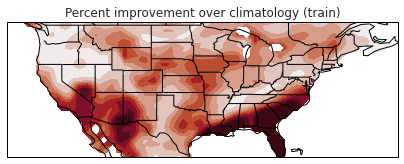

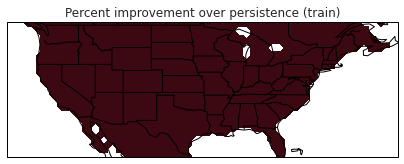

In [7]:
data_type   = 'train'
PLOT_IMPROV = True
PLOT_COEF   = False
PLOT_ERROR  = False
PLOT_CORR   = False
weighted    = True

lon = test['out'].n.unstack('n').longitude # longitude/latitudes for plotting
lat = test['out'].n.unstack('n').latitude

if PLOT_CORR:
    for model,name in list(zip(['model','clim','per'], ['linear regression','climatology','persistence'])):
        fig,ax = plot_setup(plot_range = [lon[0],lon[-1],lat[0],lat[-1]])
        c = corrs[model][data_type]
        sig = get_sig(c).astype('float')
        cp = ax.contourf(lon, lat, c.reshape(len(lat),len(lon)), cmap='cmo.balance', 
                         levels=[-.5,-.45,-.4,-.35,-.3,-.25,-.2,-.1,-.05,.05,.1,.15,.2,.25,.3,.35,.4,.45,.5], 
                         extend='both')
        h = ax.contourf(lon, lat, sig.reshape(len(lat),len(lon)), hatches=[None,None,'xx'],colors='none',
                       extend='both', levels=[.25, .75])
        ax.set_title(f'Correlation for {name} ({data_type} data)')
        if model=='per':
            cb = fig.colorbar(cp, orientation='horizontal', label=r'$\rho$')
        plt.show()

if PLOT_IMPROV: # Improvement over climatology
    var = dict() # get variance of data to standardize plots
    eps = np.finfo(np.double).eps
    var['train'] = np.var(y_train,axis=0) + eps # avoid numerical div-by-0 errors
    var['test']  = np.var(y_test, axis=0) + eps

    for model,name in list(zip(['clim','per'], ['climatology','persistence'])):
        fig,ax = plot_setup(plot_range = [lon[0],lon[-1],lat[0],lat[-1]])
        improv = 100*(mses[model][data_type][0] - mses['model'][data_type][0]) / mses[model][data_type][0]
        cp = ax.contourf(lon, lat, improv.reshape(len(lat), len(lon)),
                        cmap='cmo.balance', levels=np.linspace(-10,10,16), extend='both')
        ax.set_title(f'Percent improvement over {name} ({data_type})')
#         cb = fig.colorbar(cp, orientation='horizontal', label='% improvement')
        plt.show()

if PLOT_COEF: # plot coefficients for each variable
    for idx, name in list(zip([0,1,2], ['RMM1','RMM2','ONI'])):
        fig,ax = plot_setup(plot_range = [lon[0],lon[-1],lat[0],lat[-1]])
        cp = ax.contourf(lon, lat, x[idx,:].reshape(len(lat),len(lon)),
                        cmap='cmo.balance', levels=np.linspace(-5,5,16), extend='both')
        ax.set_title(f'Coefficient for {name}')
#         if name=='ONI':
        cb = fig.colorbar(cp, orientation='horizontal', label=f'(mm precip) per (std dev. of {name})')
        plt.show()

if PLOT_ERROR: # Plot errors for each
    levels = np.linspace(.95,1.05,15) if weighted else 15
    for model in ['model','clim','per']:
        fig,ax = plot_setup(plot_range = [lon[0],lon[-1],lat[0],lat[-1]])
        error = mses[model][data_type][0] / (var[data_type] if weighted else 1)
        cp = ax.contourf(lon, lat, error.reshape(len(lat),len(lon)),
                         cmap='cmo.amp', levels=levels, extend='both')
        ax.set_title(f'MSE for {model}')
        cb = fig.colorbar(cp, orientation='horizontal', label='MSE')
        plt.show()

Plot improvement over each  
Predict temperature instead of precipitation?  
Add significance!!

Can linear model predict MJO? I.e. can it capture the periodic behavior

## Spectral analysis

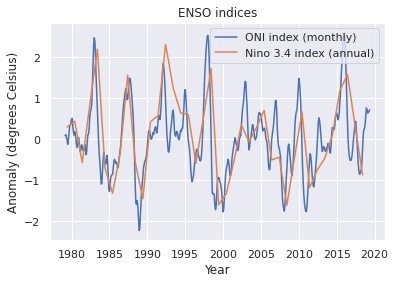

In [8]:
from datetime import datetime
# Read in NOAA indices to sanity check the ONI computation
clim_ind = pd.read_csv('/vortexfs1/scratch/kcarr/climate_indices.csv')
year = clim_ind.iloc[:,0]
nino34 = clim_ind.loc[:,'nino_34']

fig,ax = plt.subplots()
ax.plot(oni.time, oni, label='ONI index (monthly)')
ax.plot([datetime(y, 6,1) for y in year[29:]], nino34[29:], label='Nino 3.4 index (annual)')
ax.set_xlabel('Year')
ax.set_ylabel('Anomaly (degrees Celsius)')
ax.set_title('ENSO indices')
ax.legend()
plt.show()

#### Compare ENSO to MJO

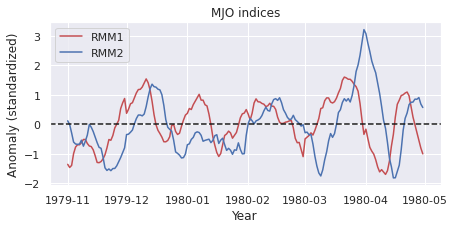

In [9]:
# t1 = '2001-01-01'
# t2 = '2001-12-31'
year = 1979
t1 = f'{year}-11-01'
t2 = f'{year+1}-04-30'
fig,ax = plt.subplots(figsize=(7,3))
# ax.plot(oni_daily.time.sel(time=slice(t1,t2)), oni_daily.sel(time=slice(t1,t2)), label='ONI',color='k',ls='--')
ax.plot(rmm1.time.sel(time=slice(t1,t2)), rmm1.sel(time=slice(t1,t2)), label='RMM1', color='r')
ax.plot(rmm2.time.sel(time=slice(t1,t2)), rmm2.sel(time=slice(t1,t2)), label='RMM2', color='b')
ax.axhline(0, color='k',linestyle='--')
ax.set_xlabel('Year')
ax.set_ylabel('Anomaly (standardized)')
# ax.set_title('ENSO & MJO indices')
ax.set_title('MJO indices')
ax.legend()
plt.show()

## Frequency domain

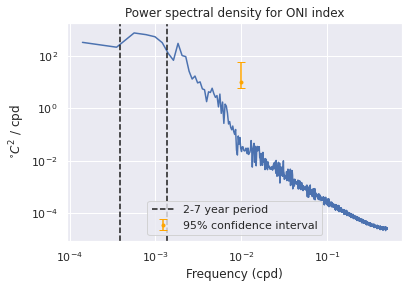

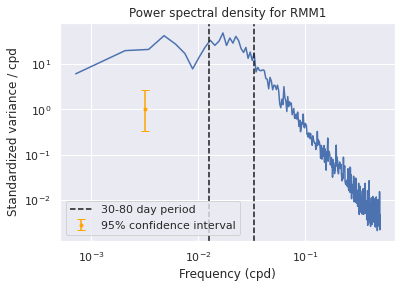

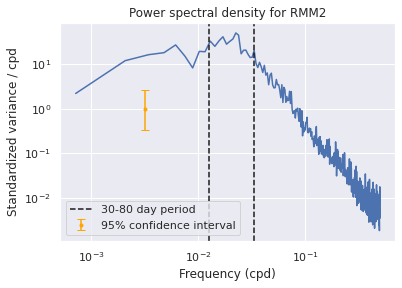

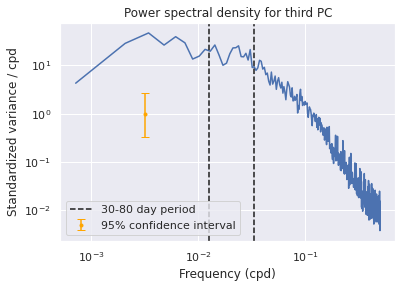

In [10]:
# test spectral function works
N=20000
t = np.arange(1,20000)
N = len(t)
dt = 1
f = 50
sig = np.sin(f*np.pi*t/(N*dt)) + np.random.randn(N)*.5

# apply to data
oni_res = spectral.autospec_density_bandavg(y=oni_daily.values, dt=1, M=3)
oni_res['ax'].axvline(x=1/(365*7),ls='--',color='k', label='2-7 year period')
oni_res['ax'].axvline(x=1/(365*2),ls='--',color='k')
oni_res['ax'].set_xlabel('Frequency (cpd)')
oni_res['ax'].set_ylabel('$^{\circ}C^2$ / cpd')
oni_res['ax'].set_title('Power spectral density for ONI index')
oni_res['ax'].legend()
plt.show()

# MJO indices
M=19
rmm1_res = spectral.autospec_density_bandavg(y=rmm1.values, dt=1, M=M, xloc=10**-2.5,yloc=1)
rmm1_res['ax'].axvline(x=1/80, ls='--',color='k', label='30-80 day period')
rmm1_res['ax'].axvline(x=1/30, ls='--',color='k')
rmm1_res['ax'].legend()
rmm1_res['ax'].set_xlabel('Frequency (cpd)')
rmm1_res['ax'].set_ylabel('Standardized variance / cpd')
rmm1_res['ax'].set_title('Power spectral density for RMM1')
plt.show()

rmm2_res = spectral.autospec_density_bandavg(y=rmm2.values, dt=1, M=M, xloc=10**-2.5,yloc=1)
rmm2_res['ax'].axvline(x=1/80, ls='--',color='k', label='30-80 day period')
rmm2_res['ax'].axvline(x=1/30, ls='--',color='k')
rmm2_res['ax'].legend()
rmm2_res['ax'].set_xlabel('Frequency (cpd)')
rmm2_res['ax'].set_ylabel('Standardized variance / cpd')
rmm2_res['ax'].set_title('Power spectral density for RMM2')
plt.show()

pc3_res = spectral.autospec_density_bandavg(y=pc3.values, dt=1, M=M, xloc=10**-2.5,yloc=1)
pc3_res['ax'].axvline(x=1/80, ls='--',color='k', label='30-80 day period')
pc3_res['ax'].axvline(x=1/30, ls='--',color='k')
pc3_res['ax'].legend()
pc3_res['ax'].set_xlabel('Frequency (cpd)')
pc3_res['ax'].set_ylabel('Standardized variance / cpd')
pc3_res['ax'].set_title('Power spectral density for third PC')
plt.show()

Compute variance explained

In [11]:
dx = rmm1_res['freq'][1]-rmm1_res['freq'][0]
integral = np.sum(rmm1_res['Y'] * dx) # total integral (should be equal to 1, data is standardized)
vals = rmm1_res['Y'][(rmm1_res['freq'] <= 1/30) & (rmm1_res['freq'] >= 1/80)] # sum values under curve
rmm1_expvar = np.sum(dx*vals) # area under curve

# print(f'RMM1 total variance:          {integral:.3f}')
print(f'RMM1 30-80 day explained variance: {rmm1_expvar:.3f}\n')

dx = rmm2_res['freq'][1]-rmm2_res['freq'][0]
integral = np.sum(rmm2_res['Y'] * dx) # total integral (should be equal to 1, data is standardized)
vals = rmm2_res['Y'][(rmm2_res['freq'] <= 1/30) & (rmm2_res['freq'] >= 1/80)] # sum values under curve
rmm2_expvar = np.sum(dx*vals) # area under curve

# print(f'RMM2 total variance:          {integral:.3f}')
print(f'RMM2 30-80 day explained variance: {rmm2_expvar:.3f}\n')

dx = pc3_res['freq'][1]-pc3_res['freq'][0]
integral = np.sum(pc3_res['Y'] * dx) # total integral (should be equal to 1, data is standardized)
vals = pc3_res['Y'][(pc3_res['freq'] <= 1/30) & (pc3_res['freq'] >= 1/80)] # sum values under curve
pc3_expvar = np.sum(dx*vals) # area under curve

# print(f'RMM2 total variance:          {integral:.3f}')
print(f'PC3 30-80 day explained variance:  {pc3_expvar:.3f}\n')

dx = oni_res['freq'][1]-oni_res['freq'][0]
integral = np.sum(oni_res['Y'] * dx) # total integral (should be equal to 1, data is standardized)
vals = oni_res['Y'][(oni_res['freq'] <= 1/(2*365)) & (oni_res['freq'] >= 1/(7*365))] # sum values under curve
oni_expvar = np.sum(dx*vals)/integral # area under curve

# print(f'RMM2 total variance:          {integral:.3f}')
print(f'ONI 2-7 year explained variance:   {oni_expvar:.3f}')

RMM1 30-80 day explained variance: 0.582

RMM2 30-80 day explained variance: 0.602

PC3 30-80 day explained variance:  0.367

ONI 2-7 year explained variance:   0.624


# Misc...

### Distribution of MJO over months

In [29]:
phase_counts   = Counter(mjo_phase[mjo_phase>0].values)
monthly_counts = Counter(mjo_phase[mjo_phase>0].time.dt.month.values)

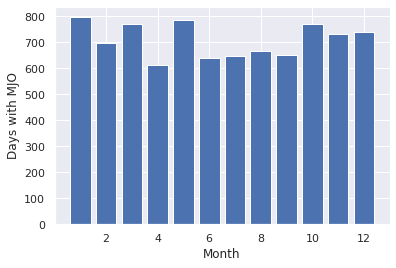

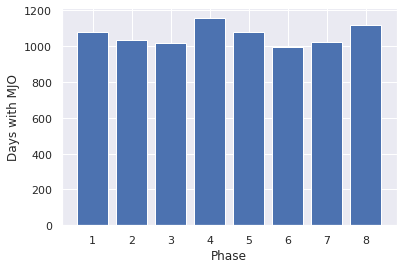

In [30]:
fig,ax = plt.subplots()
ax.bar(monthly_counts.keys(), monthly_counts.values())
ax.set_xlabel('Month')
ax.set_ylabel('Days with MJO')
plt.show()

fig,ax = plt.subplots()
ax.bar(phase_counts.keys(), phase_counts.values())
ax.set_xlabel('Phase')
ax.set_ylabel('Days with MJO')
plt.show()

## Precipitation clustering / ENSO analysis

### Identify precipitation regions

In [9]:
print('clustering')
prect_ = prect.stack(posn=['lat','lon'])

idx = np.where(~np.isnan(prect_.isel(time=0)).values)[0]
vals = prect_.isel(posn=idx).values

from sklearn.cluster import KMeans
from copy import deepcopy

# Fit kmeans
model = KMeans(n_clusters=9)
model.fit(vals.T)

# Get labels
labels = np.nan*deepcopy(prect_.isel(time=0, drop=True))
labels[idx] = model.labels_
labels = labels.unstack()

k_vals = np.unique(labels.values)
k_vals = k_vals[~np.isnan(k_vals)]

cluster_mask = xr.concat([labels for _ in range(len(k_vals))], dim='cluster').assign_coords({'cluster':k_vals})
for i,c in enumerate(cluster_mask.cluster.values):
    cluster_mask.values[i,:] = 1. * cluster_mask.values[i,:]==c

cluster_mask.values[cluster_mask.values==0] = np.nan    

clustering


**Plot clusters**

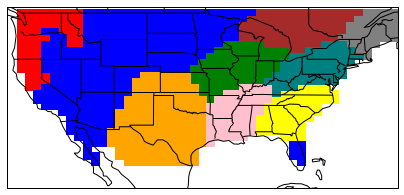

In [10]:
def plot_clusters(labels, colors, plot_range=[-125.25, -66, 22.5, 50]):
    '''Function plots clusters on map'''
    x,y = np.meshgrid(labels.lon.values, labels.lat.values)
    k_vals = np.unique(labels.values)
    k_vals = k_vals[~np.isnan(k_vals)]
    fig, ax = plot_setup()
    for i, k in enumerate(k_vals):
        color = ListedColormap(colors[i])
        mask = (labels.values==k)*1.
        mask[mask==0] = np.nan
        ax.pcolormesh(x,y,mask, cmap=color)
    return fig, ax

colors = ['red','blue','green','orange','pink','yellow', 'brown', 'gray', 'teal']
fig, ax = plot_clusters(labels, colors = colors)

## Composite of El-Nino events

In [8]:
nino_days = oni_daily[oni_daily > oni_daily.std()].time
nina_days = oni_daily[oni_daily < -oni_daily.std()].time

In [9]:
nino_composite = prect.sel(time=nino_days).mean(dim='time')
nina_composite = prect.sel(time=nina_days).mean(dim='time')

/vortexfs1/home/kcarr/.conda/envs/torch_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


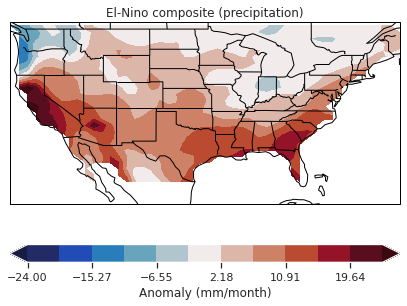

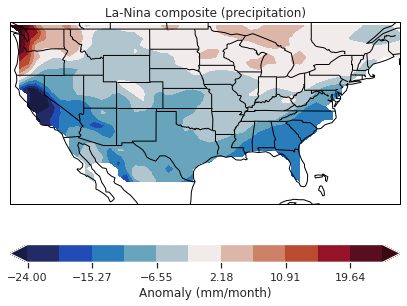

In [10]:
a = 1000*3600*24*365/12 # conversion factor from m/s to mm/month

fig,ax = plot_setup()
cp = ax.contourf(nino_composite.lon, nino_composite.lat, a*nino_composite, cmap='cmo.balance',
                levels=np.linspace(-24,24,12), extend='both')
cb = fig.colorbar(cp, orientation='horizontal', label='Anomaly (mm/month)')
ax.set_title(r'El-Nino composite (precipitation)')
plt.show()

fig,ax = plot_setup()
cp = ax.contourf(nina_composite.lon, nina_composite.lat, a*nina_composite, cmap='cmo.balance',
                levels=np.linspace(-24,24,12), extend='both')
cb = fig.colorbar(cp, orientation='horizontal', label='Anomaly (mm/month)')
ax.set_title(r'La-Nina composite (precipitation)')
plt.show()

#### ONI timeseries

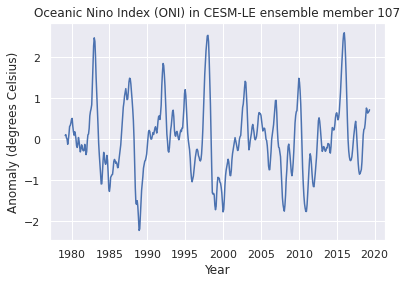

In [10]:
## plot ONI index
fig,ax = plt.subplots()
ax.plot(oni.time, oni)
ax.set_xlabel('Year')
ax.set_ylabel('Anomaly (degrees Celsius)')
ax.set_title('Oceanic Nino Index (ONI) in CESM-LE ensemble member 107')
plt.show()